<a href="https://colab.research.google.com/github/671454/dat158-ML-assignment2/blob/main/DAT158ML2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 DAT158

*Modeller vi bruker: Random Forrest for regresjon*

***Måling av modellens ytelse:***

Vi skal bruke både metrikker som **Root Mean Squared Error** (RMSE) og **Mean Absolute Error** (MAE) Da disse vil gi oss en helhetlig forståelse av modellens **nøyaktighet**. En kombinasjon av disse gir innsikt i gjennomsnittlig feilmargin og risikoen for store feil(avvik).


**Hovedsteg:**
1. Datainnsamling (hentes fra Kaggle)
2. Preprossesering av data
- 2.1 Rense data
- 2.2 Feature Engineering
- 2.3 Normalisre data om nødvendig
3. Train_validate_test (f : X -> y)
4. Modelltrening
5. Modellvalidering
- 5.1 Optimalisere hyperparametre
6. Modelltesting på nye data
7. Implementere modellen i Gradio



In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sklearn

# DEL 1 - Datainnsamling


In [3]:
train_url = "https://raw.githubusercontent.com/667029/dat158-ML-assignment2/refs/heads/main/df_train.csv"
test_url = "https://raw.githubusercontent.com/667029/dat158-ML-assignment2/refs/heads/main/df_test.csv"

train_data = pd.read_csv(train_url)
test_data = pd.read_csv(test_url)

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14105 entries, 0 to 14104
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               14105 non-null  object 
 1   price              14105 non-null  float64
 2   bedrooms           14105 non-null  int64  
 3   grade              14105 non-null  int64  
 4   has_basement       14105 non-null  bool   
 5   living_in_m2       14105 non-null  float64
 6   renovated          14105 non-null  bool   
 7   nice_view          14105 non-null  bool   
 8   perfect_condition  14105 non-null  bool   
 9   real_bathrooms     14105 non-null  int64  
 10  has_lavatory       14105 non-null  bool   
 11  single_floor       14105 non-null  bool   
 12  month              14105 non-null  int64  
 13  quartile_zone      14105 non-null  int64  
dtypes: bool(6), float64(2), int64(5), object(1)
memory usage: 964.3+ KB


# DEL 2 - Preprosessering av data


"Date" er av typen String og må konverteres til Datetime

In [5]:
train_data["date"] = pd.to_datetime(train_data["date"])
test_data["date"] = pd.to_datetime(test_data["date"])

In [6]:
#Sletter den tidligere 'month'-variablen
train_data.drop("month", axis=1, inplace=True)
test_data.drop("month", axis=1, inplace=True)

#Må ekstrahere komponenter fra 'date', da R.F.Regressor ikke klarer å jobbe med dateTime-typen
train_data["year"] = train_data["date"].dt.year
train_data["month"] = train_data["date"].dt.month
train_data["day"] = train_data["date"].dt.day

test_data["year"] = test_data["date"].dt.year
test_data["month"] = test_data["date"].dt.month
test_data["day"] = test_data["date"].dt.day

train_data.drop("date", axis=1, inplace=True)
test_data.drop("date", axis=1, inplace=True)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14105 entries, 0 to 14104
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              14105 non-null  float64
 1   bedrooms           14105 non-null  int64  
 2   grade              14105 non-null  int64  
 3   has_basement       14105 non-null  bool   
 4   living_in_m2       14105 non-null  float64
 5   renovated          14105 non-null  bool   
 6   nice_view          14105 non-null  bool   
 7   perfect_condition  14105 non-null  bool   
 8   real_bathrooms     14105 non-null  int64  
 9   has_lavatory       14105 non-null  bool   
 10  single_floor       14105 non-null  bool   
 11  quartile_zone      14105 non-null  int64  
 12  year               14105 non-null  int32  
 13  month              14105 non-null  int32  
 14  day                14105 non-null  int32  
dtypes: bool(6), float64(2), int32(3), int64(4)
memory usage: 909.2 KB


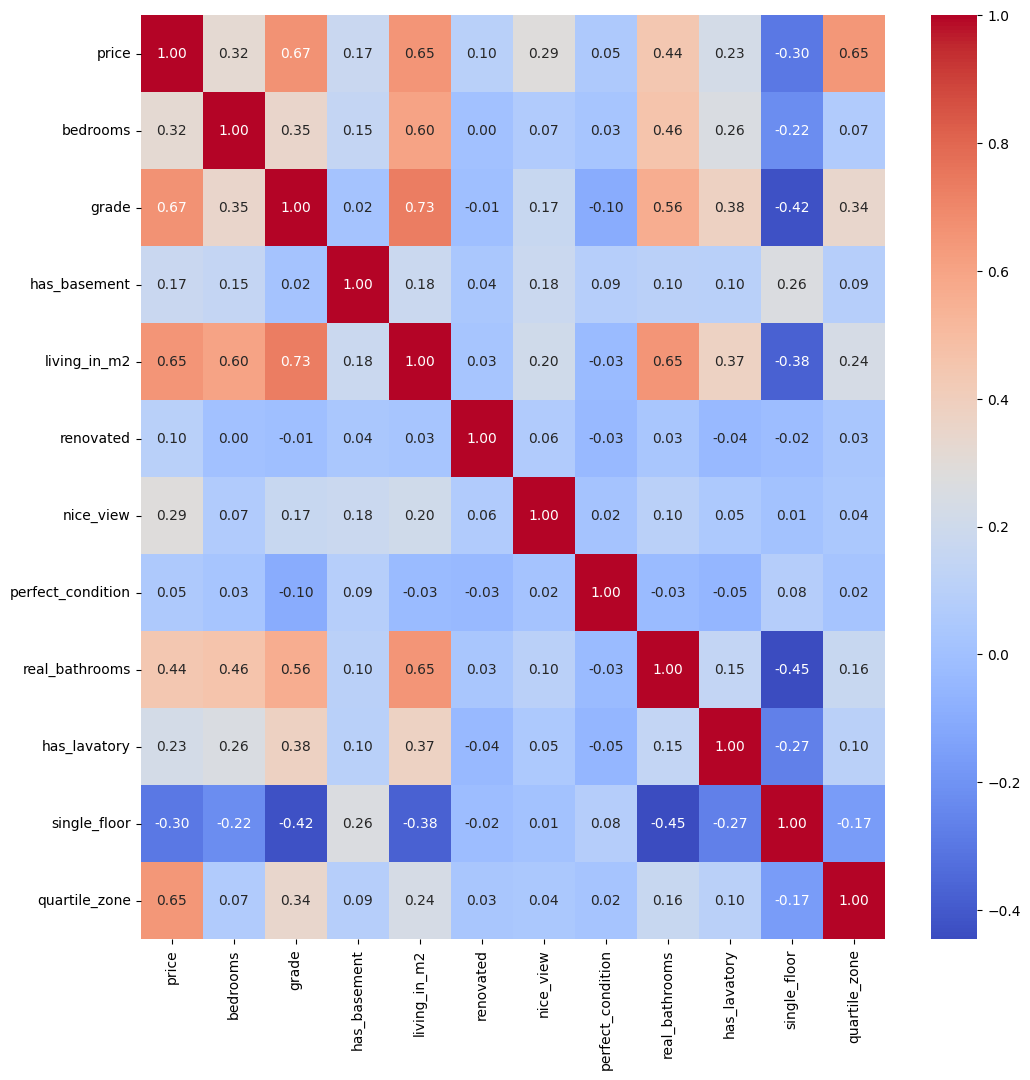

In [30]:
#Undersøke den nye korr.matrisen
plt.figure(figsize=(12,12))
sns.heatmap(train_data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

Velger å year, month og day

In [29]:
#Fjerne year, month og day fra datasettet
train_data.drop(["year", "month", "day"], axis=1, inplace=True)
test_data.drop(["year", "month", "day"], axis=1, inplace=True)

**Oversikt over prisfordeling:**

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(train_data["price"])
plt.show()

**Innstallerer nødvendig verktøy for å lage en Pandas profile raport, som gir oss en samlet og grei raport på datasettet:**

In [ ]:
!pip install pandas_profiling


In [ ]:
!pip install pydantic-settings

In [31]:
from ydata_profiling import ProfileReport
profile = ProfileReport(train_data, title="Pandas Profiling Report", minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Vi har ingen manglende verdier i datasettet

Fra rapporten kan vi se at det er stor ubalanse i features som "renovated", "nice_view" og "perfekt condition".
Vi skal bruke Random Forest og den er ganske robust mot ubalanserte features, så det gjenstår å se om disse må modifiseres slik at de blir mer balanserte eller ikke.

***NB NB: Husk bruke feature importance etter trening av modell for å kunne se om variabler faktisk har positiv innvirkning på modellens estimeringsvne.***

# DEL 3 - Split data

In [15]:
X = train_data.drop("price", axis=1) #Features
y = train_data["price"] #Lables

In [16]:
X.head()

,bedrooms,grade,has_basement,living_in_m2,renovated,nice_view,perfect_condition,real_bathrooms,has_lavatory,single_floor,quartile_zone,year,month,day
0,3,7,False,120.77390,False,False,False,1,False,True,2,2014,6,20
1,5,9,True,310.29602,True,True,False,3,False,True,4,2015,4,20
2,4,9,False,311.22505,False,False,False,2,True,False,4,2014,8,13
3,4,9,False,282.42512,False,False,False,2,True,False,2,2015,4,8
4,3,7,True,162.58025,False,False,False,2,True,True,2,2015,2,11


In [17]:
y.head()

,price
0,237000.0
1,1328000.0
2,790500.0
3,431000.0
4,199000.0


# Tren Modellen

In [18]:
#Initialiserer modellen
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

Model-baseline verdier

In [19]:
#Valider modell med kryssvalidering
from sklearn.model_selection import cross_val_score

scores_mae = cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error")
scores_rmse = cross_val_score(model, X, y, cv=5, scoring="neg_root_mean_squared_error")

mean_mae = -scores_mae.mean()
mean_rmse = -scores_rmse.mean()

print(f"Mean MAE: {mean_mae:.2f}")
print(f"Mean RMSE: {mean_rmse:.2f}")

Mean MAE: 85417.23
Mean RMSE: 121777.83


# Optimalisering

In [20]:
#from skopt import BayesSearchCV
#from skopt.space import Real, Integer, Categorical
#Definere hyperparam området:
#param_space = {
#    'n_estimators': (100, 1000),
#   'max_depth': (5, 50),
#    'min_samples_split': (2, 20),
#    'min_samples_leaf': (1, 10),
#    'max_features': ['sqrt', 'log2'] # Removed 'auto' from the list of possible values for max_features
#}

# Initialiser Bayesian optimization med BayesSearchCV
#opt = BayesSearchCV(
#    RandomForestRegressor(random_state=42),
#    param_space,
#    n_iter=32,  # Antall kombinasjoner å prøve
#    cv=5,       # Kryssvalidering med 5 fold
#    scoring='neg_mean_absolute_error',
#    n_jobs=-1,
#    random_state=42
#)

# Kjør Bayesian optimization på treningsdataene
#opt.fit(X, y)

# Hent de beste hyperparametrene
#best_params = opt.best_params_
#print("Beste hyperparametere funnet med Bayesian Optimization:", best_params)

# Hent den beste modellen
#best_model = opt.best_estimator_

Output:

Beste hyperparametere funnet med Bayesian Optimization: OrderedDict({'max_depth': 48, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 1000})

In [32]:
best_model2 = RandomForestRegressor(
    max_depth=48,
    max_features='log2',
    min_samples_leaf=2,
    min_samples_split=7,
    n_estimators=1000,
    random_state=42
)

best_model2.fit(X, y)

RandomForestRegressor(max_depth=48, max_features='log2', min_samples_leaf=2,
                      min_samples_split=7, n_estimators=1000, random_state=42)

Som vi kan se scorer modellen noe bedre etter å ha brukt Bayesian-søk på hyperparametrene, men fortsatt dårlig

In [33]:
scores_mae = cross_val_score(best_model2, X, y, cv=5, scoring="neg_mean_absolute_error")
scores_rmse = cross_val_score(best_model2, X, y, cv=5, scoring="neg_root_mean_squared_error")

mean_mae = -scores_mae.mean()
mean_rmse = -scores_rmse.mean()

print(f"Mean MAE: {mean_mae:.2f}")
print(f"Mean RMSE: {mean_rmse:.2f}")

Mean MAE: 81850.33
Mean RMSE: 117492.73


# Feature Importances
Vi kan se at "quartile_zone", "grade" og "living_in_m2" er de av størst betydning. Men vi ser også at den tidligere 'date'-variablen som ble delt opp i 3 nye variabler day, month og year er av lav viktighet. Derfor kan disse fjernes

In [24]:
importances = best_model2.feature_importances_

feature_importances = pd.Series(importances, index=X.columns)
sorted_importances = feature_importances.sort_values(ascending=False)

print(sorted_importances)

quartile_zone        0.312446
grade                0.216349
living_in_m2         0.215073
real_bathrooms       0.055431
nice_view            0.038152
bedrooms             0.036573
day                  0.031413
month                0.022962
single_floor         0.020525
has_basement         0.017475
has_lavatory         0.012228
perfect_condition    0.009069
renovated            0.007557
year                 0.004746
dtype: float64
